In [1]:
import csv
import json
import math
import os
import re
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

os.chdir('/Users/cory.quammen/data/PediatricAirways/AtlasDatabase')

In [2]:
def ReadCSVFileIntoDict(filename, header=True):
    d = {}
    with open(filename) as csvFile:
        reader = csv.reader(csvFile, delimiter=',', quotechar='"')
        headerRow = []
        for row in reader:
            if (len(row) > 0 and row[0].startswith('#')):
                continue
            elif (header):
                header = False
                headerRow = row
                #print headerRow
                for col in row:
                    d[col] = []
            else:
                #print row
                if (len(headerRow) > 0):
                    for (name, value) in zip(headerRow, row):
                        d[name].append(value)
                else:
                    for (i,value) in zip(xrange(len(row)), row):
                        colName = 'col%d' % i
                        if (not d.has_key(colName)):
                            d[colName] = []
                        d[colName].append(value)
    return d

In [3]:
# Read all files in the directory
files = os.listdir(os.getcwd())

# Filter the cross section files
files = filter(lambda x: '_ALL_CROSS_SECTIONS.csv' in x, files)
def GetScanID(s):
    m = re.search('[0-9][0-9][0-9][0-9]', s)
    return m.group(0)
scanIDs = map(lambda x: GetScanID(x), files)

In [17]:
# Gather up all curves into a dictionary indexed by scan ID
def float_list(lst):
    return [float(x) for x in lst]

def Distance(x1, x2):
    dx = x1[0] - x2[0]
    dy = x1[1] - x2[1]
    dz = x1[2] - x2[2]
    return math.sqrt(dx*dx + dy*dy + dz*dz)

curveDict = {}
for scanID in scanIDs:
    filename = scanID + '_ALL_CROSS_SECTIONS.csv'
    curveCSV = ReadCSVFileIntoDict(filename)
    
    # Chop off zero-area entries
    startIdx = 0
    if (curveCSV['area'][0] == '0'):
        startIdx += 1
    endIdx = len(curveCSV['area'])-1
    if (curveCSV['area'][-1] == '0'):
        endIdx -= 1

    # create the centerline
    centerline = zip(float_list(curveCSV['center of mass:0'][startIdx:endIdx]),
                     float_list(curveCSV['center of mass:1'][startIdx:endIdx]),
                     float_list(curveCSV['center of mass:2'][startIdx:endIdx]))
    cumulativeDistance = [0]
    for (idx, x, y) in zip(xrange(len(centerline)-1), centerline[:-1], centerline[1:]):
        cumulativeDistance.append(Distance(x, y) + cumulativeDistance[idx])
    
    # Normalize the cumulative distance to range [0.0, 1.0]
    parametricDistance = [(t / cumulativeDistance[-1]) for t in cumulativeDistance]
        
    curveDict[scanID] = {'cross_sectional_area' : curveCSV['area'][startIdx:endIdx],
                         'centerline' : centerline,
                         't' : parametricDistance}


In [18]:
# Get the patient info
patientInfo = ReadCSVFileIntoDict('PatientInfo.csv')

def CleanNumberString(s):
    return ''.join([c for c in s if c in '0123456789-.'])

for (scanID, age) in zip(patientInfo['Number'], patientInfo['Age in months']):
    if (not curveDict.has_key(scanID)):
        continue
    curveDict[scanID]['age'] = float(CleanNumberString(age))

# Clean out curves for which we don't have patient data
for key in curveDict.keys():
    if (not curveDict[key].has_key('age')):
        print "Could not find age for scan", key
        print "Removing from database"
        curveDict.pop(key, None)

Could not find age for scan 1024
Removing from database


In [19]:
# Find index of point on curve closest to landmark
landmarksOfInterest = ['TVC', 'Subglottis', 'EpiglottisTip', 'TracheaCarina']
for scanID in curveDict.keys():
    # Find the landmark file for the scan
    filename = scanID + '_LANDMARKS.fcsv'
    with open(filename) as landmarksFile:        
        landmarksCSV = ReadCSVFileIntoDict(filename, header=False)
    xcol = [-float(x) for x in landmarksCSV['col1']]
    ycol = [-float(x) for x in landmarksCSV['col2']]
    zcol = [float(x) for x in landmarksCSV['col3']]
    labelcol = landmarksCSV['col11']
    curveDict[scanID]['landmarks'] = {}
    for (x, y, z, label) in zip(xcol, ycol, zcol, labelcol):
        if (label in landmarksOfInterest):
            # Find curve point nearest to landmark
            x = float(x)
            y = float(y)
            z = float(z)
            landmarkPosition = (x, y, z)
            centerline = curveDict[scanID]['centerline']
            distances = map(lambda x: Distance(landmarkPosition, x), centerline)
            minDist = min(distances)
            minDistIndex = distances.index(minDist)

            curveDict[scanID]['landmarks'][label] = {'closest_index' : minDistIndex,
                                                     'position' : landmarkPosition}


In [20]:
# Get average parametric coordinate of the various landmarks
averageT = {}
for landmark in landmarksOfInterest:
    averageT[landmark] = {'cumulative' : 0.0,
                          'count' : 0}
    for scanID in curveDict.keys():
        curveInfo = curveDict[scanID]
        try:
            landmarkDict = curveInfo['landmarks'][landmark]
        except:
            curveDict.pop(scanID, None)
            continue
        tIndex = landmarkDict['closest_index']
        t = curveInfo['t'][tIndex]
        averageT[landmark]['cumulative'] += t
        averageT[landmark]['count'] += 1

    averageT[landmark] = averageT[landmark]['cumulative'] / averageT[landmark]['count']

print averageT


{'Subglottis': 0.851473273138592, 'TracheaCarina': 0.9952152475835728, 'EpiglottisTip': 0.7142995384618409, 'TVC': 0.8165279726952717}


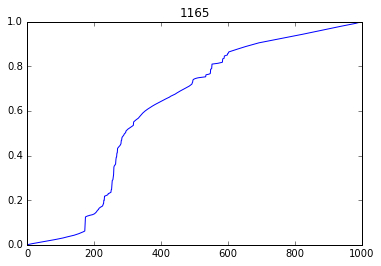

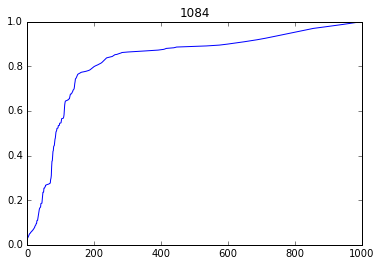

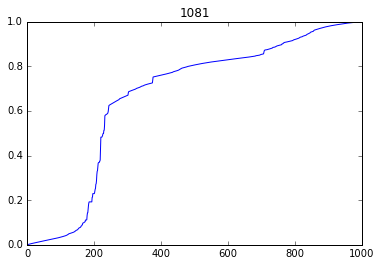

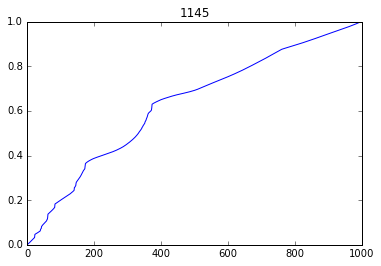

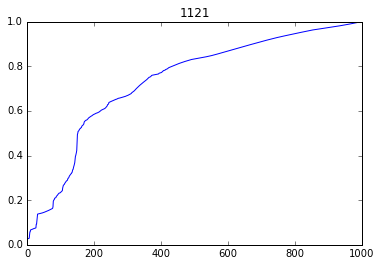

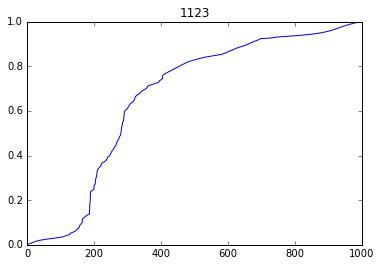

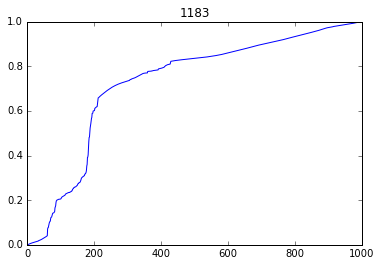

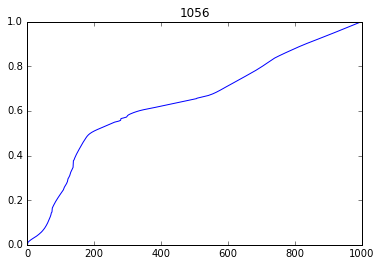

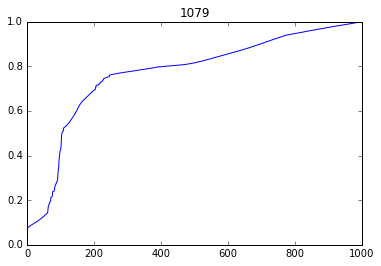

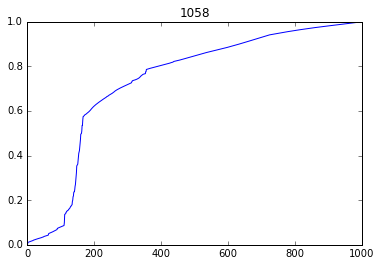

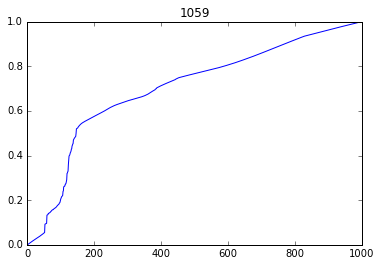

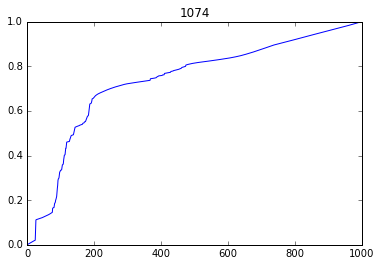

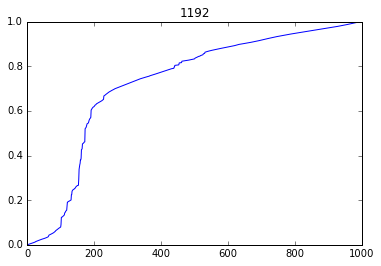

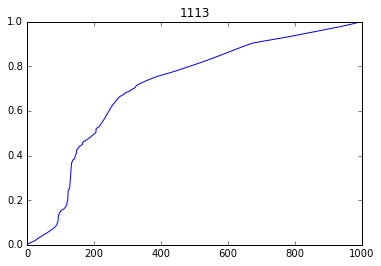

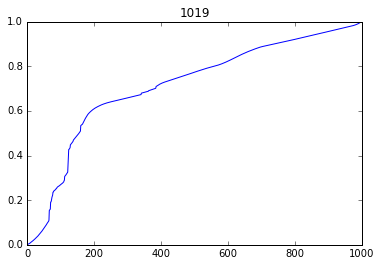

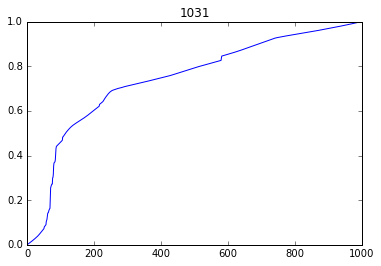

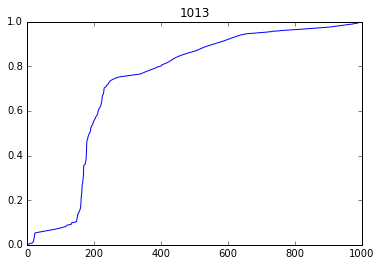

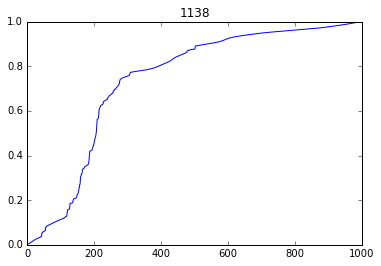

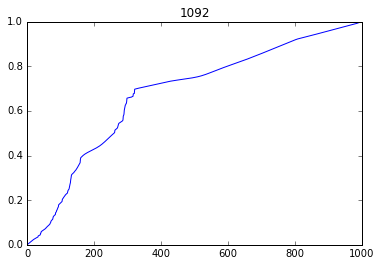

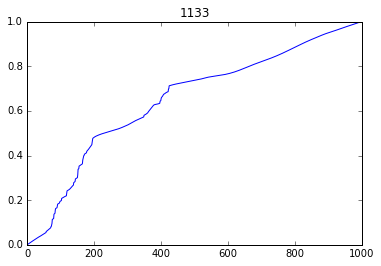

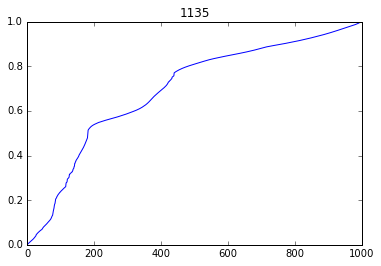

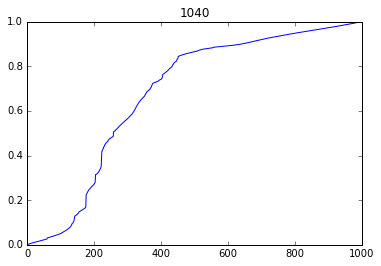

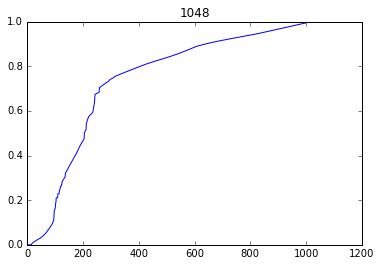

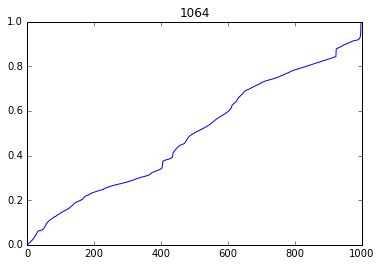

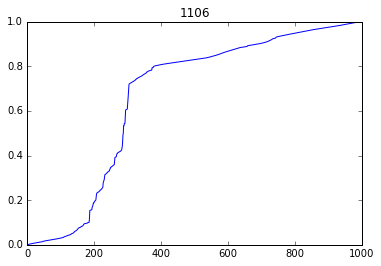

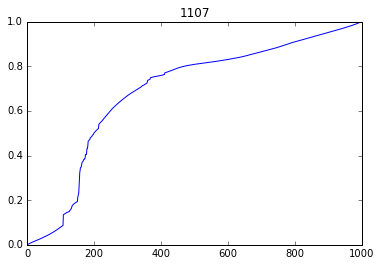

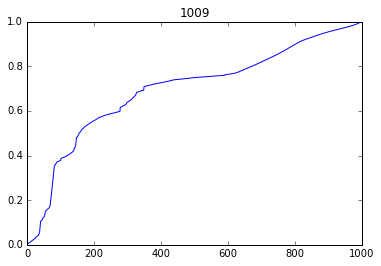

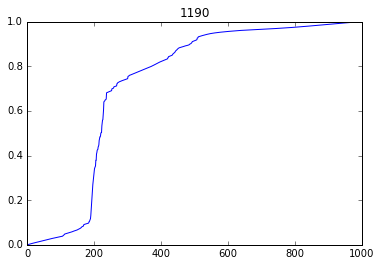

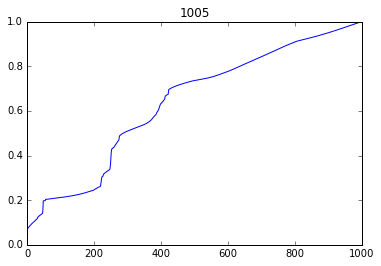

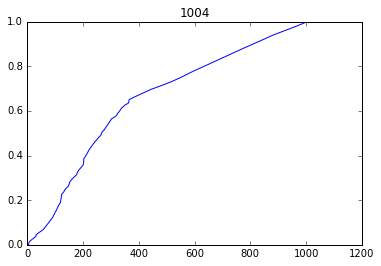

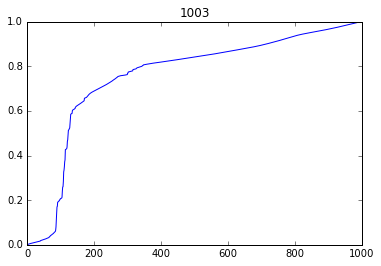

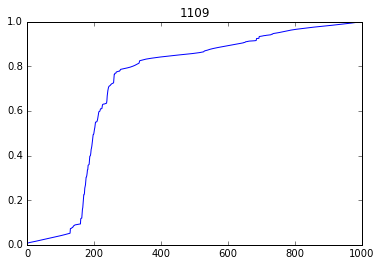

In [21]:
for scanID in curveDict.keys():
    plt.plot(curveDict[scanID]['t'])
    plt.plot()
    plt.title(scanID)
    plt.show()

In [16]:
curveDict['1192']['cross_sectional_area'][-1]

'0'